In [3]:
 ### importamos todas la librerias necesarias para el analisis de los datos e importancion de las mismas
from sqlalchemy import create_engine
import pandas as pd
import itables
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
####Configuracion para unirse a la base de datos de la empresa
config = {
    'user': 'root',
    'password': 'curso123',
    'host': '127.0.0.1',
    'database': 'predict_mant'
}

# Crear un motor de conexión
engine = create_engine(f"mysql+pymysql://{config['user']}:{config['password']}@{config['host']}/{config['database']}")

In [7]:
# Consultas para obtener los datos de cada tabla 
# Consultas para obtener los datos de cada tabla
query_fallas = "SELECT * FROM fallas"
query_mantenimientos = "SELECT * FROM mantenimiento"
query_registros = "SELECT * FROM registros"

In [9]:
# Ejecutar las consultas y almacenar los resultados en DataFrames
# Leer los datos en DataFrames
df_fallas = pd.read_sql(query_fallas, engine)
df_mantenimientos = pd.read_sql(query_mantenimientos, engine)
df_registros = pd.read_sql(query_registros, engine)

In [11]:
#df_registros = pd.read_csv('registros.csv')
#df_fallas = pd.read_csv('fallas.csv')
#df_mantenimientos= pd.read_csv('mantenimiento.csv')

In [13]:
df_fallas.head()

id_falla                fecha maquina_ID    falla
0         1  2015-01-05 06:00:00          1  comp4\r
1         2  2015-03-06 06:00:00          1  comp1\r
2         3  2015-04-20 06:00:00          1  comp2\r
3         4  2015-06-19 06:00:00          1  comp4\r
4         5  2015-09-02 06:00:00          1  comp4\r

In [15]:
# Cerrar el cursor y la conexión
engine.dispose()

In [17]:
# Convertir la columna 'fecha' a formato datetime y los demas elementos a variables categoricas y asociamos
df_fallas['fecha'] = pd.to_datetime(df_fallas['fecha'])

# Convertir la columna 'maquina_id' a entero
df_fallas['maquina_ID'] = df_fallas['maquina_ID'].astype(int)

# Convertir la columna 'codigo_falla' a variable categórica
df_fallas['falla'] = df_fallas['falla'].astype('category')
mapeo_categorias = {
    'comp2\r': 'Falla Térmica',
    'comp1\r': 'Falla Magnética',
    'comp4\r': 'Falla Retroalimentación',
    'comp3\r': 'Falla Comunicación'
}

# Reemplazar los nombres de las categorías
df_fallas['falla'] = df_fallas['falla'].map(mapeo_categorias)

In [19]:
itables.show(df_fallas)

In [21]:
#ahora hacemos lo mismo para la tabla de mantenimiento
df_mantenimientos['fecha']=pd.to_datetime(df_mantenimientos['fecha'])
df_mantenimientos['maquina_ID']=df_mantenimientos['maquina_ID'].astype(int)
df_mantenimientos['componente']=df_mantenimientos['componente'].astype('category')
print(df_mantenimientos['componente'].value_counts())

mapeo_categorias = {
    'comp2\r': 'Correccion de eje atascado del motor',
    'comp1\r': 'Verificacion del punto de corte',
    'comp4\r': 'Cambio de contactor de arranque',
    'comp3\r': 'Mantenimiento codigo del PLC'
}
df_mantenimientos['componente']=df_mantenimientos['componente'].map(mapeo_categorias)

componente
comp2\r    863
comp4\r    811
comp3\r    808
comp1\r    804
Name: count, dtype: int64


In [23]:
itables.show(df_mantenimientos)

In [25]:
df_registros.isna().sum()

id_registros    0
fecha           0
maquina_ID      0
voltaje         0
rotacion        0
presion         0
vibracion       0
dtype: int64

In [27]:
df_registros.iloc[50000:50005]

id_registros                fecha maquina_ID      voltaje     rotacion  \
50000         50001  2015-09-16 09:00:00          6  188.0202619  527.8225259   
50001         50002  2015-09-16 10:00:00          6   161.358253  417.0610209   
50002         50003  2015-09-16 11:00:00          6  178.2713261  501.9936649   
50003         50004  2015-09-16 12:00:00          6  171.7641552  399.3783423   
50004         50005  2015-09-16 13:00:00          6  148.9304635  419.3383073   

           presion      vibracion  
50000  89.28483229  42.65732736\r  
50001  100.2210269  36.44718774\r  
50002  100.9209969  34.01113119\r  
50003  103.8382856  42.58493274\r  
50004  99.04517272  44.87006951\r

In [29]:
#df_registros = df_registros.dropna(axis=0, how='any')

In [31]:
## ahora para la tabla de los registros
###########################
df_registros['fecha'] = pd.to_datetime(df_registros['fecha'])
df_registros['maquina_ID']=df_registros['maquina_ID'].astype(int)
df_registros['voltaje']=df_registros['voltaje'].astype(float)
df_registros['rotacion']=df_registros['rotacion'].astype(float)
df_registros['presion']=df_registros['presion'].astype(float)
df_registros['vibracion']=df_registros['vibracion'].astype(float)

In [33]:
itables.show(df_registros)

In [35]:
### crear columnas con fechas trucnadas
# Crear una nueva columna con la fecha truncada a minutos
df_registros['fecha_truncada'] = df_registros['fecha'].dt.floor('min')
df_fallas['fecha_truncada'] = df_fallas['fecha'].dt.floor('min')
df_mantenimientos['fecha_truncada'] = df_mantenimientos['fecha'].dt.floor('min')


In [37]:
# Establecer el índice en las columnas que deseas unir
df_registros.set_index(['maquina_ID', 'fecha_truncada'], inplace=True)
df_fallas.set_index(['maquina_ID', 'fecha_truncada'], inplace=True)
df_mantenimientos.set_index(['maquina_ID', 'fecha_truncada'], inplace=True)

In [39]:
 ######Unir las tablas
df_union = df_registros.join(df_fallas, how='left', lsuffix='_registros', rsuffix='_fallas')
df_union = df_union.join(df_mantenimientos, how='left', lsuffix='_df_union', rsuffix='_mantenimientos')
df_union = df_union.reset_index()

In [41]:
itables.show(df_union)

In [43]:
## eliminamos las columnas innecesarias
df_union=df_union.drop(['id_falla','fecha_fallas','id_mantenimiento','fecha'],axis=1)

In [45]:
itables.show(df_union)

In [47]:
#Renombramos la columna componente
df_union = df_union.rename(columns={'componente': 'T_Mantenimiento'})

In [49]:
###Remplazamos los valores NaN por la inexistencia de fallas
df_union['falla'] = df_union['falla'].cat.add_categories('ninguno')
df_union['falla'] = df_union['falla'].fillna('ninguno')

In [51]:
## ahora hacemos lo mismo para la columna de mantenimientos 
df_union['T_Mantenimiento']=df_union['T_Mantenimiento'].cat.add_categories('SinTarea')
df_union['T_Mantenimiento']=df_union['T_Mantenimiento'].fillna('SinTarea')

In [53]:
itables.show(df_union)

In [55]:
df_union.isna().sum()

maquina_ID         0
fecha_truncada     0
id_registros       0
fecha_registros    0
voltaje            0
rotacion           0
presion            0
vibracion          0
falla              0
T_Mantenimiento    0
dtype: int64

In [57]:
### ahora vamos a estudiar el comportamiento de los parametros para ello separamos la tabla
# Separa el DataFrame en 5 tablas distintas
df_falla_termica = df_union.loc[df_union['falla'] == 'Falla Térmica']
df_falla_magnetica = df_union.loc[df_union['falla'] == 'Falla Magnética']
df_falla_retroalimentacion = df_union.loc[df_union['falla'] == 'Falla Retroalimentación']
df_falla_comunicacion = df_union.loc[df_union['falla'] == 'Falla Comunicación']
df_ninguna = df_union.loc[df_union['falla'] == 'ninguno']

In [59]:
itables.show(df_falla_comunicacion)

In [61]:
itables.show(df_falla_retroalimentacion)

In [63]:
print(df_union.columns)

Index(['maquina_ID', 'fecha_truncada', 'id_registros', 'fecha_registros',
       'voltaje', 'rotacion', 'presion', 'vibracion', 'falla',
       'T_Mantenimiento'],
      dtype='object')


In [65]:
# Crea series de tiempo para cada DataFrame
# Convierte la columna "fecha_registros" a tipo datetime
# Crea series de tiempo para cada DataFrame
serie_falla_termica = df_falla_termica[['fecha_registros', 'voltaje']].set_index('fecha_registros')
serie_falla_magnetica = df_falla_magnetica[['fecha_registros', 'voltaje']].set_index('fecha_registros')
serie_falla_retroalimentacion = df_falla_retroalimentacion[['fecha_registros', 'voltaje']].set_index('fecha_registros')
serie_falla_comunicacion = df_falla_comunicacion[['fecha_registros', 'voltaje']].set_index('fecha_registros')
serie_ninguna = df_ninguna[['fecha_registros', 'voltaje']].set_index('fecha_registros')

In [67]:
serie_falla_termica = serie_falla_termica.sort_index()
serie_falla_magnetica = serie_falla_magnetica.sort_index()
serie_falla_retroalimentacion = serie_falla_retroalimentacion.sort_index()
serie_falla_comunicacion = serie_falla_comunicacion.sort_index()
serie_ninguna = serie_ninguna.sort_index()

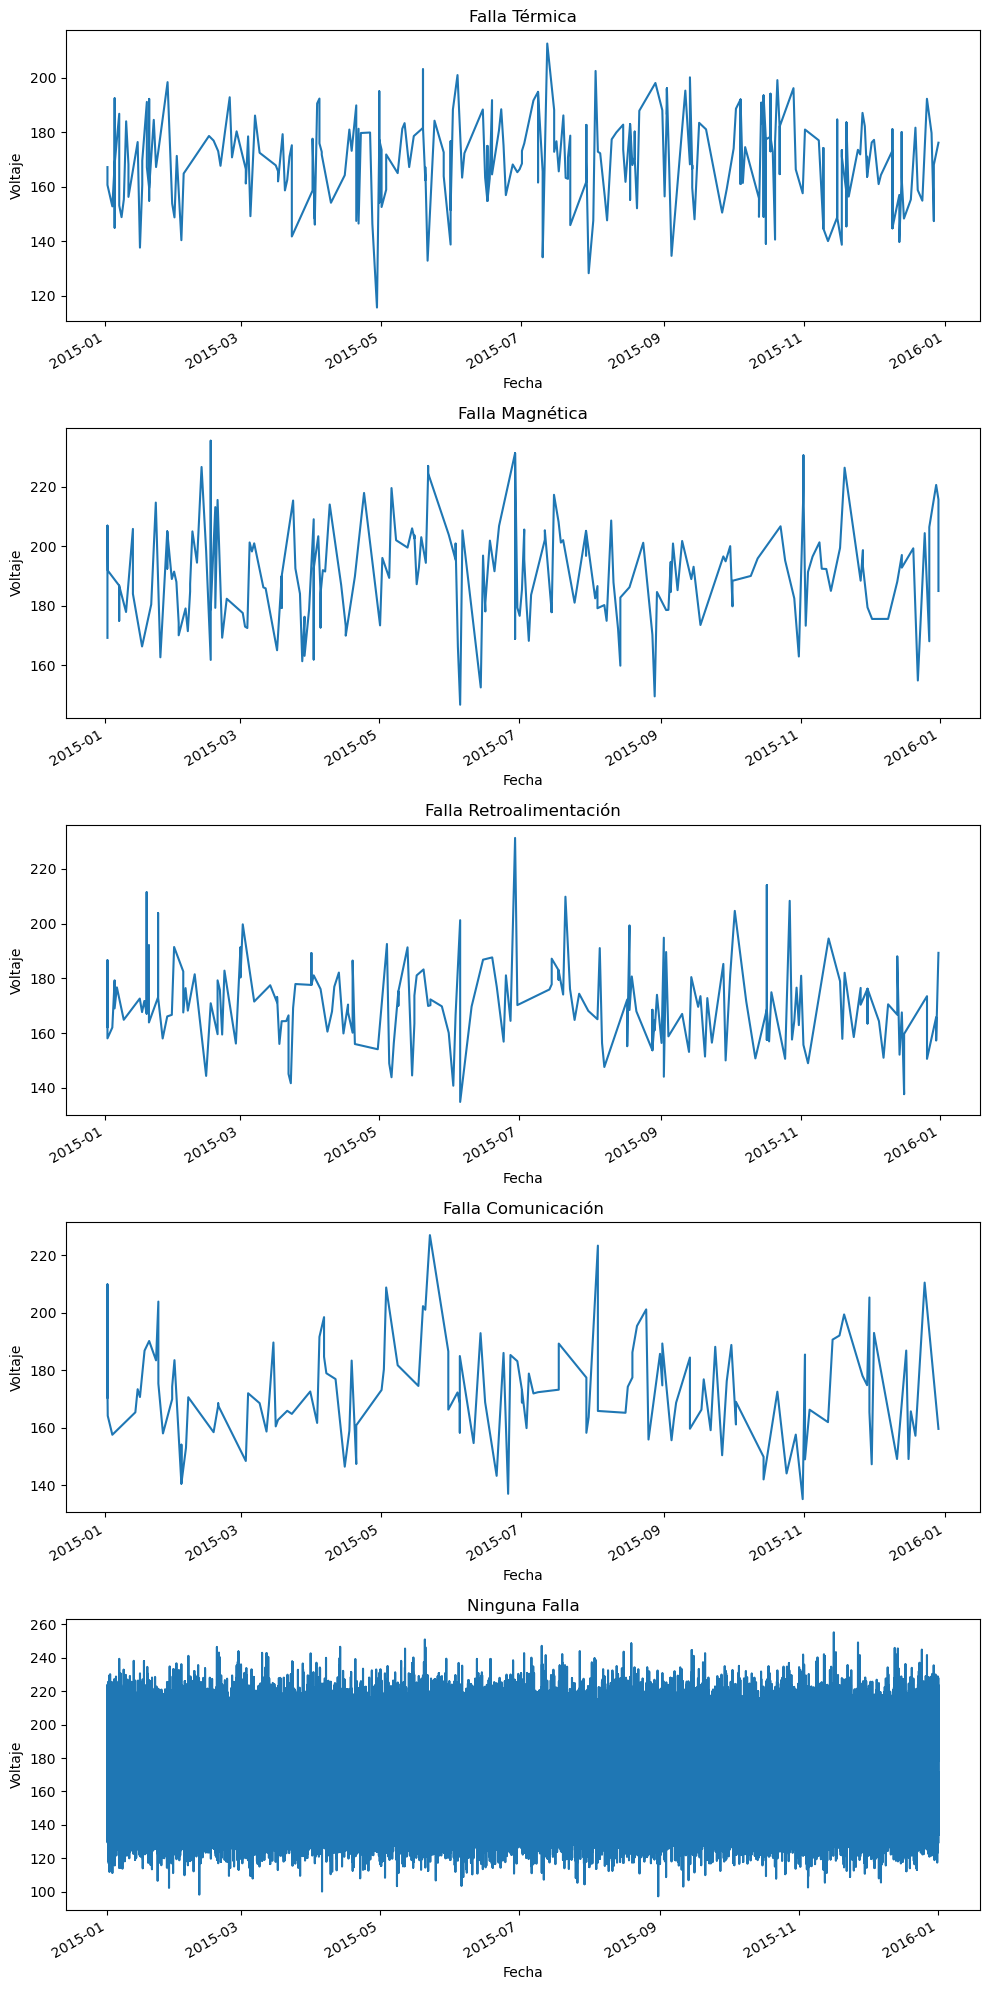

In [69]:
# Crea gráficos para cada serie de tiempo
fig, axs = plt.subplots(5, figsize=(10, 20))

serie_falla_termica['voltaje'].plot(ax=axs[0])
axs[0].set_title('Falla Térmica')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Voltaje')

serie_falla_magnetica['voltaje'].plot(ax=axs[1])
axs[1].set_title('Falla Magnética')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Voltaje')

serie_falla_retroalimentacion['voltaje'].plot(ax=axs[2])
axs[2].set_title('Falla Retroalimentación')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('Voltaje')

serie_falla_comunicacion['voltaje'].plot(ax=axs[3])
axs[3].set_title('Falla Comunicación')
axs[3].set_xlabel('Fecha')
axs[3].set_ylabel('Voltaje')

serie_ninguna['voltaje'].plot(ax=axs[4])
axs[4].set_title('Ninguna Falla')
axs[4].set_xlabel('Fecha')
axs[4].set_ylabel('Voltaje')

plt.tight_layout()
plt.show()

In [71]:
# Calcula el valor promedio de voltaje en cada falla
promedio_falla_termica = df_falla_termica['voltaje'].mean()
promedio_falla_magnetica = df_falla_magnetica['voltaje'].mean()
promedio_falla_retroalimentacion = df_falla_retroalimentacion['voltaje'].mean()
promedio_falla_comunicacion = df_falla_comunicacion['voltaje'].mean()
promedio_ninguna = df_ninguna['voltaje'].mean()

# Imprime los resultados
print("Promedio de voltaje en falla térmica:", promedio_falla_termica)
print("Promedio de voltaje en falla magnética:", promedio_falla_magnetica)
print("Promedio de voltaje en falla retroalimentación:", promedio_falla_retroalimentacion)
print("Promedio de voltaje en falla comunicación:", promedio_falla_comunicacion)
print("Promedio de voltaje sin falla:", promedio_ninguna)

Promedio de voltaje en falla térmica: 169.83660652926267
Promedio de voltaje en falla magnética: 190.08433446487342
Promedio de voltaje en falla retroalimentación: 170.85995529225093
Promedio de voltaje en falla comunicación: 172.9580228388601
Promedio de voltaje sin falla: 170.77023101253818


In [73]:
# Crea series de tiempo para cada DataFrame
# Convierte la columna "fecha_registros" a tipo datetime
# Crea series de tiempo para cada DataFrame
serie_falla_termica2 = df_falla_termica[['fecha_registros', 'rotacion']].set_index('fecha_registros')
serie_falla_magnetica2 = df_falla_magnetica[['fecha_registros', 'rotacion']].set_index('fecha_registros')
serie_falla_retroalimentacion2 = df_falla_retroalimentacion[['fecha_registros', 'rotacion']].set_index('fecha_registros')
serie_falla_comunicacion2 = df_falla_comunicacion[['fecha_registros', 'rotacion']].set_index('fecha_registros')
serie_ninguna2 = df_ninguna[['fecha_registros', 'rotacion']].set_index('fecha_registros')

In [75]:
#### ahora ordenamos los valores en el tiempo
serie_falla_termica2 = serie_falla_termica2.sort_index()
serie_falla_magnetica2 = serie_falla_magnetica2.sort_index()
serie_falla_retroalimentacion2 = serie_falla_retroalimentacion2.sort_index()
serie_falla_comunicacion2 = serie_falla_comunicacion2.sort_index()
serie_ninguna2 = serie_ninguna2.sort_index()

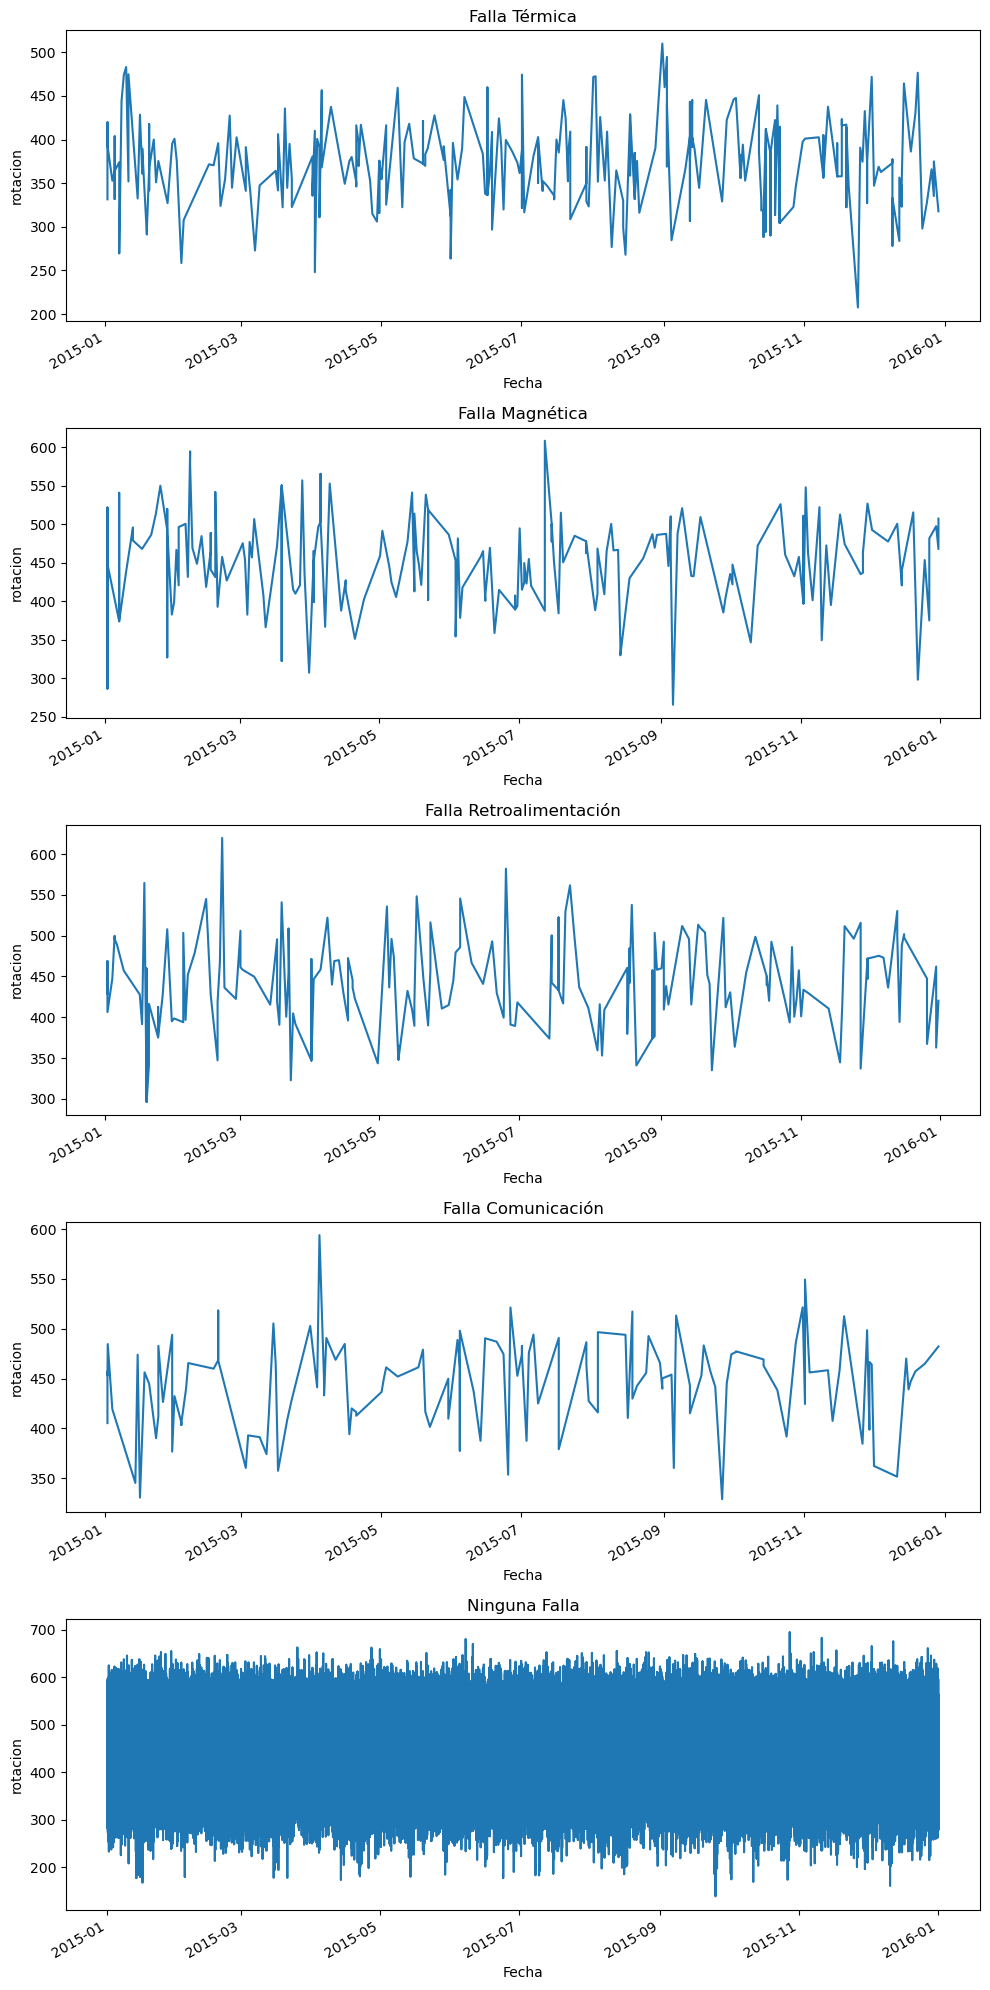

In [77]:
# Crea gráficos para cada serie de tiempo
fig, axs = plt.subplots(5, figsize=(10, 20))

serie_falla_termica2['rotacion'].plot(ax=axs[0])
axs[0].set_title('Falla Térmica')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('rotacion')

serie_falla_magnetica2['rotacion'].plot(ax=axs[1])
axs[1].set_title('Falla Magnética')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('rotacion')

serie_falla_retroalimentacion2['rotacion'].plot(ax=axs[2])
axs[2].set_title('Falla Retroalimentación')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('rotacion')

serie_falla_comunicacion2['rotacion'].plot(ax=axs[3])
axs[3].set_title('Falla Comunicación')
axs[3].set_xlabel('Fecha')
axs[3].set_ylabel('rotacion')

serie_ninguna2['rotacion'].plot(ax=axs[4])
axs[4].set_title('Ninguna Falla')
axs[4].set_xlabel('Fecha')
axs[4].set_ylabel('rotacion')

plt.tight_layout()
plt.show()

In [79]:
# Calcula el valor promedio de voltaje en cada falla
promedio_falla_termica2 = df_falla_termica['rotacion'].mean()
promedio_falla_magnetica2 = df_falla_magnetica['rotacion'].mean()
promedio_falla_retroalimentacion2 = df_falla_retroalimentacion['rotacion'].mean()
promedio_falla_comunicacion2 = df_falla_comunicacion['rotacion'].mean()
promedio_ninguna2 = df_ninguna['rotacion'].mean()

# Imprime los resultados
print("Promedio de rotacion en falla térmica:", promedio_falla_termica2)
print("Promedio de rotacion en falla magnética:", promedio_falla_magnetica2)
print("Promedio de rotacion en falla retroalimentación:", promedio_falla_retroalimentacion2)
print("Promedio de rotacion en falla comunicación:", promedio_falla_comunicacion2)
print("Promedio de rotacion sin falla:", promedio_ninguna2)

Promedio de rotacion en falla térmica: 372.0028232668202
Promedio de rotacion en falla magnética: 446.1173726968354
Promedio de rotacion en falla retroalimentación: 440.91574046900365
Promedio de rotacion en falla comunicación: 446.0757786398963
Promedio de rotacion sin falla: 446.6156022736773


In [81]:
## revisamos que los promedios de valores en las maquinas sean los mismos para todos
promedio_voltaje_por_machine = df_union.groupby('maquina_ID')['vibracion'].mean()
print(promedio_voltaje_por_machine)

maquina_ID
1      40.590806
2      40.304552
3      40.473856
4      40.341372
5      40.266174
         ...    
96     40.248031
97     40.560740
98     40.506352
99     40.526209
100    40.321097
Name: vibracion, Length: 100, dtype: float64


In [83]:
# Crea series de tiempo para cada DataFrame
# Convierte la columna "fecha_registros" a tipo datetime
# Crea series de tiempo para cada DataFrame
serie_falla_termica3 = df_falla_termica[['fecha_registros', 'presion']].set_index('fecha_registros')
serie_falla_magnetica3 = df_falla_magnetica[['fecha_registros', 'presion']].set_index('fecha_registros')
serie_falla_retroalimentacion3 = df_falla_retroalimentacion[['fecha_registros', 'presion']].set_index('fecha_registros')
serie_falla_comunicacion3 = df_falla_comunicacion[['fecha_registros', 'presion']].set_index('fecha_registros')
serie_ninguna3 = df_ninguna[['fecha_registros', 'presion']].set_index('fecha_registros')

In [85]:
#### ahora ordenamos los valores en el tiempo
serie_falla_termica3 = serie_falla_termica3.sort_index()
serie_falla_magnetica3 = serie_falla_magnetica3.sort_index()
serie_falla_retroalimentacion3 = serie_falla_retroalimentacion3.sort_index()
serie_falla_comunicacion3 = serie_falla_comunicacion3.sort_index()
serie_ninguna3 = serie_ninguna3.sort_index()

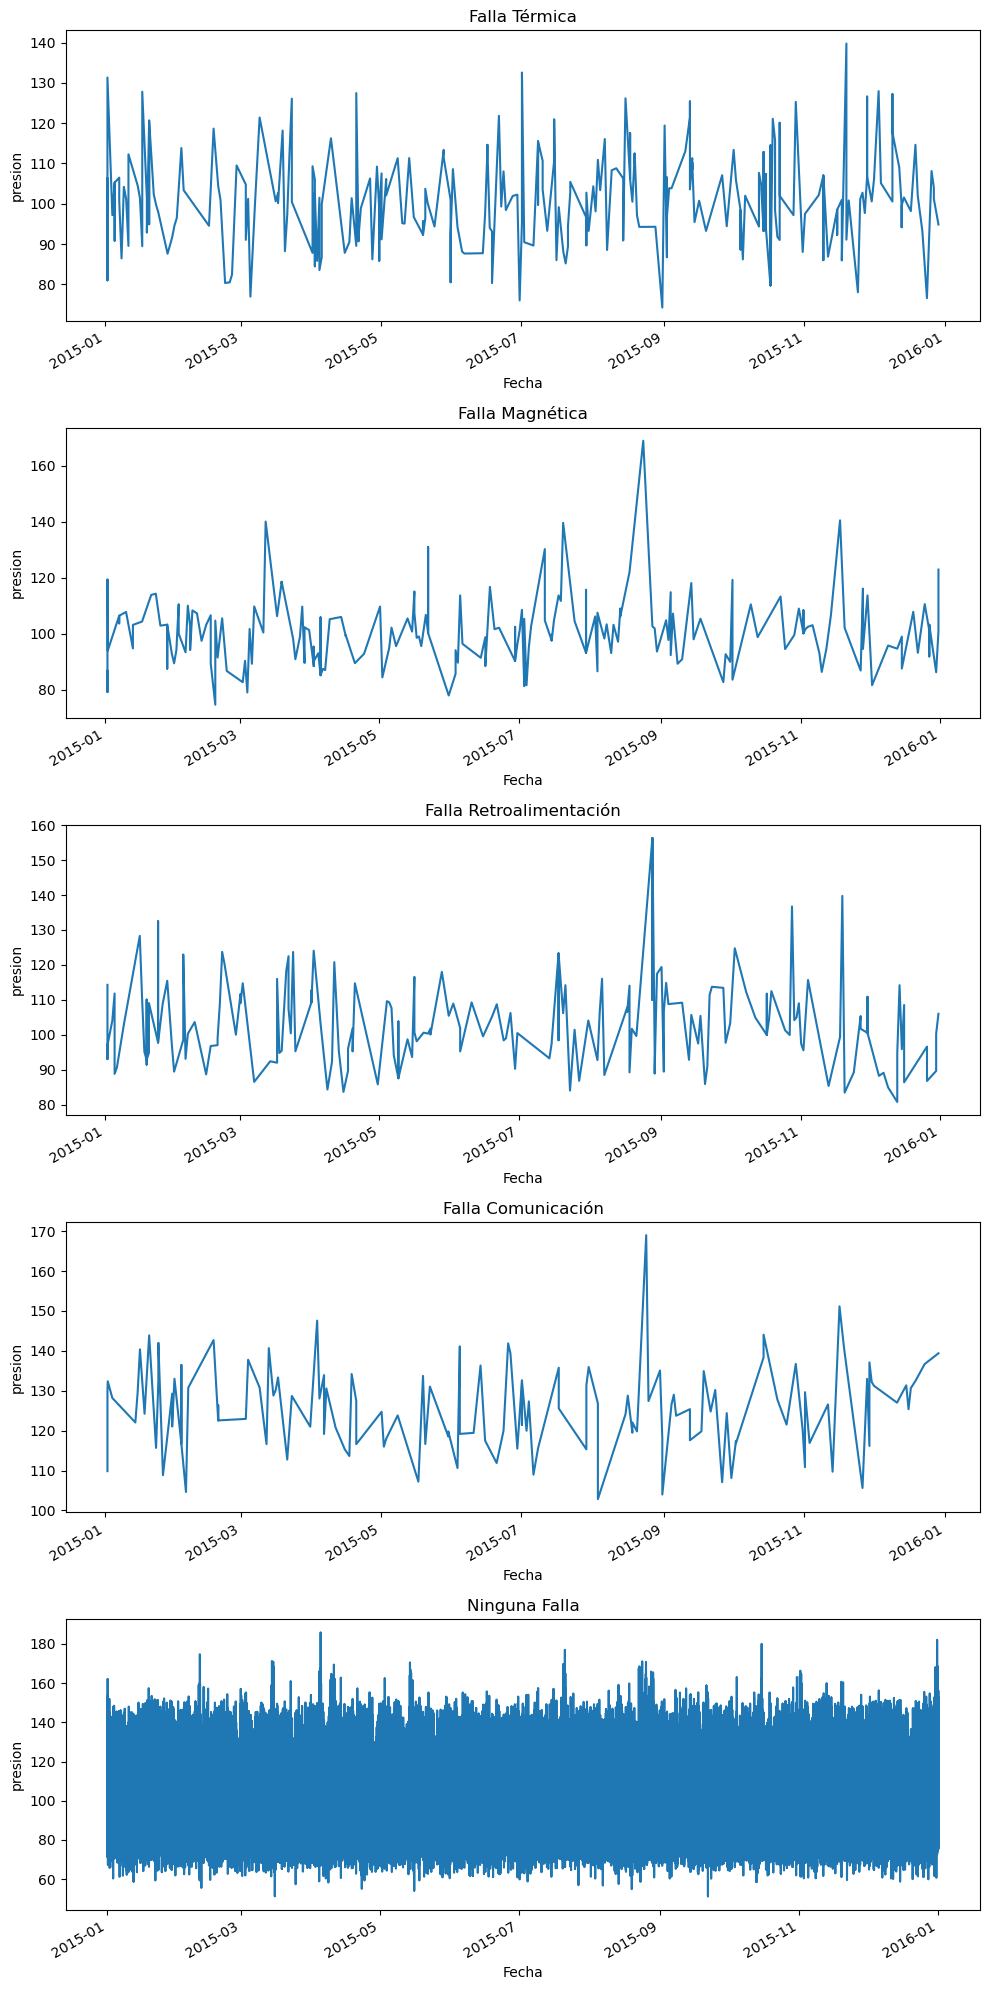

In [87]:
# Crea gráficos para cada serie de tiempo
fig, axs = plt.subplots(5, figsize=(10, 20))

serie_falla_termica3['presion'].plot(ax=axs[0])
axs[0].set_title('Falla Térmica')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('presion')

serie_falla_magnetica3['presion'].plot(ax=axs[1])
axs[1].set_title('Falla Magnética')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('presion')

serie_falla_retroalimentacion3['presion'].plot(ax=axs[2])
axs[2].set_title('Falla Retroalimentación')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('presion')

serie_falla_comunicacion3['presion'].plot(ax=axs[3])
axs[3].set_title('Falla Comunicación')
axs[3].set_xlabel('Fecha')
axs[3].set_ylabel('presion')

serie_ninguna3['presion'].plot(ax=axs[4])
axs[4].set_title('Ninguna Falla')
axs[4].set_xlabel('Fecha')
axs[4].set_ylabel('presion')

plt.tight_layout()
plt.show()

In [89]:
# Calcula el valor promedio de voltaje en cada falla
promedio_falla_termica3 = df_falla_termica['presion'].mean()
promedio_falla_magnetica3 = df_falla_magnetica['presion'].mean()
promedio_falla_retroalimentacion3 = df_falla_retroalimentacion['presion'].mean()
promedio_falla_comunicacion3 = df_falla_comunicacion['presion'].mean()
promedio_ninguna3 = df_ninguna['presion'].mean()

# Imprime los resultados
print("Promedio de presion en falla térmica:", promedio_falla_termica3)
print("Promedio de presion en falla magnética:", promedio_falla_magnetica3)
print("Promedio de presion en falla retroalimentación:", promedio_falla_retroalimentacion3)
print("Promedio de presion en falla comunicación:", promedio_falla_comunicacion3)
print("Promedio de presion sin falla:", promedio_ninguna3)

Promedio de presion en falla térmica: 100.88075269686635
Promedio de presion en falla magnética: 100.82657363075948
Promedio de presion en falla retroalimentación: 103.12719735966789
Promedio de presion en falla comunicación: 125.6026182150259
Promedio de presion sin falla: 100.83822069458634


In [91]:
# Crea series de tiempo para cada DataFrame
# Convierte la columna "fecha_registros" a tipo datetime
# Crea series de tiempo para cada DataFrame
serie_falla_termica4 = df_falla_termica[['fecha_registros', 'vibracion']].set_index('fecha_registros')
serie_falla_magnetica4 = df_falla_magnetica[['fecha_registros', 'vibracion']].set_index('fecha_registros')
serie_falla_retroalimentacion4 = df_falla_retroalimentacion[['fecha_registros', 'vibracion']].set_index('fecha_registros')
serie_falla_comunicacion4 = df_falla_comunicacion[['fecha_registros', 'vibracion']].set_index('fecha_registros')
serie_ninguna4 = df_ninguna[['fecha_registros', 'vibracion']].set_index('fecha_registros')

In [93]:
#### ahora ordenamos los valores en el tiempo
serie_falla_termica4 = serie_falla_termica4.sort_index()
serie_falla_magnetica4 = serie_falla_magnetica4.sort_index()
serie_falla_retroalimentacion4 = serie_falla_retroalimentacion4.sort_index()
serie_falla_comunicacion4 = serie_falla_comunicacion4.sort_index()
serie_ninguna4 = serie_ninguna4.sort_index()

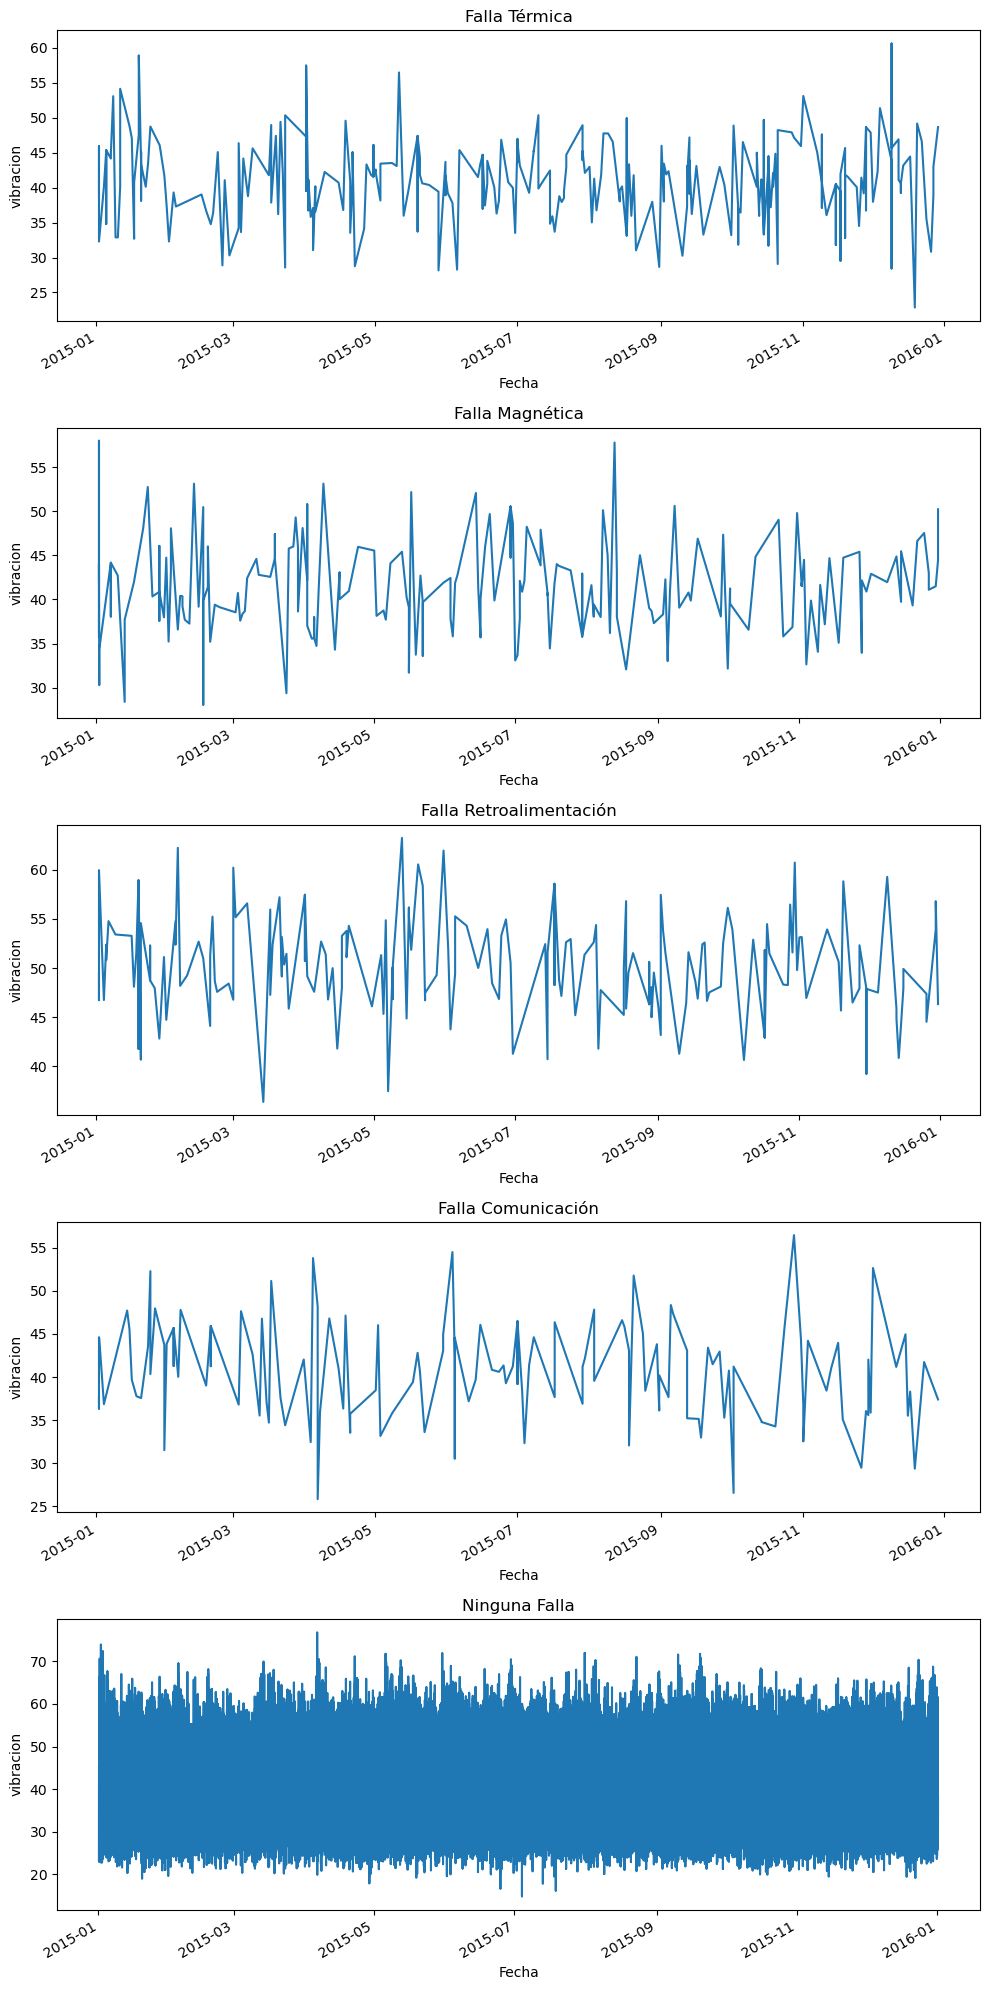

In [95]:
# Crea gráficos para cada serie de tiempo
fig, axs = plt.subplots(5, figsize=(10, 20))

serie_falla_termica4['vibracion'].plot(ax=axs[0])
axs[0].set_title('Falla Térmica')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('vibracion')

serie_falla_magnetica4['vibracion'].plot(ax=axs[1])
axs[1].set_title('Falla Magnética')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('vibracion')

serie_falla_retroalimentacion4['vibracion'].plot(ax=axs[2])
axs[2].set_title('Falla Retroalimentación')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('vibracion')

serie_falla_comunicacion4['vibracion'].plot(ax=axs[3])
axs[3].set_title('Falla Comunicación')
axs[3].set_xlabel('Fecha')
axs[3].set_ylabel('vibracion')

serie_ninguna4['vibracion'].plot(ax=axs[4])
axs[4].set_title('Ninguna Falla')
axs[4].set_xlabel('Fecha')
axs[4].set_ylabel('vibracion')

plt.tight_layout()
plt.show()

In [97]:
# Calcula el valor promedio de voltaje en cada falla
promedio_falla_termica4 = df_falla_termica['vibracion'].mean()
promedio_falla_magnetica4 = df_falla_magnetica['vibracion'].mean()
promedio_falla_retroalimentacion4 = df_falla_retroalimentacion['vibracion'].mean()
promedio_falla_comunicacion4 = df_falla_comunicacion['vibracion'].mean()
promedio_ninguna4 = df_ninguna['vibracion'].mean()

# Imprime los resultados
print("Promedio de vibracion en falla térmica:", promedio_falla_termica4)
print("Promedio de vibracion en falla magnética:", promedio_falla_magnetica4)
print("Promedio de vibracion en falla retroalimentación:", promedio_falla_retroalimentacion4)
print("Promedio de vibracion en falla comunicación:", promedio_falla_comunicacion4)
print("Promedio de vibracion sin falla:", promedio_ninguna4)

Promedio de vibracion en falla térmica: 41.15581267004608
Promedio de vibracion en falla magnética: 41.23564109642405
Promedio de vibracion en falla retroalimentación: 50.294897071033205
Promedio de vibracion en falla comunicación: 40.76464935378238
Promedio de vibracion sin falla: 40.38126759600402


In [99]:
print(df_union.columns.tolist())

['maquina_ID', 'fecha_truncada', 'id_registros', 'fecha_registros', 'voltaje', 'rotacion', 'presion', 'vibracion', 'falla', 'T_Mantenimiento']


In [101]:
## ahora vamos a sacar promedios por cada 3 hras
def priorizar_falla(x):
    fallas = [v for v in x.values if v != 'ninguno']
    return fallas[0] if fallas else 'ninguno'
def priorizar_tareas(x):
    tareas=[v for v in x.values if v != 'SinTarea']
    return tareas[0] if tareas else 'SinTarea'

df_union_resampled = df_union.groupby('maquina_ID').resample('3h', on='fecha_truncada').agg({
    'voltaje': 'mean',
    'rotacion':'mean',
    'presion':'mean',
    'vibracion':'mean',
    'falla': priorizar_falla,
    'T_Mantenimiento':priorizar_tareas
})

In [103]:
df_union_resampled = df_union_resampled.reset_index()
df_maquina_2 = df_union_resampled[df_union_resampled['maquina_ID'] == 2]
itables.show(df_maquina_2)

In [105]:
# Calcula el tiempo medio entre la ocurrencia de las fallas
df_union_resampled['falla_ocurrida'] = df_union_resampled['falla'].apply(lambda x: 1 if x != 'ninguno' else 0)
df_union_resampled['fecha_registros'] = pd.to_datetime(df_union['fecha_registros'])
df_union_resampled['tiempo_entre_fallas'] = df_union_resampled[df_union_resampled['falla_ocurrida'] == 1].groupby('maquina_ID')['fecha_registros'].diff()
df_union_resampled['TMEF'] = df_union_resampled.groupby('maquina_ID')['tiempo_entre_fallas'].transform(lambda x: x.mean(skipna=True))

# Calcula el tiempo medio entre tareas de mantenimiento
df_union_resampled['mantenimiento_realizado'] = df_union_resampled['T_Mantenimiento'].apply(lambda x: 1 if x != 'SinTarea' else 0)
df_union_resampled['tiempo_entre_mantenimiento'] = df_union_resampled[df_union_resampled['mantenimiento_realizado'] == 1].groupby('maquina_ID')['fecha_registros'].diff()
df_union_resampled['TMEB'] = df_union_resampled.groupby('maquina_ID')['tiempo_entre_mantenimiento'].transform(lambda x: x.mean(skipna=True))

In [107]:
itables.show(df_union_resampled)

In [109]:
df_union_resampled = df_union_resampled.drop(['fecha_registros', 'tiempo_entre_fallas','tiempo_entre_mantenimiento'], axis=1)

In [111]:
itables.show(df_union_resampled)

In [113]:
print(df_union_resampled.columns.tolist())


['maquina_ID', 'fecha_truncada', 'voltaje', 'rotacion', 'presion', 'vibracion', 'falla', 'T_Mantenimiento', 'falla_ocurrida', 'TMEF', 'mantenimiento_realizado', 'TMEB']


In [113]:
# Exporta el dataframe 'df_union_resampled' a un archivo CSV
df_union_resampled.to_csv('Tabla_minable', index=False)


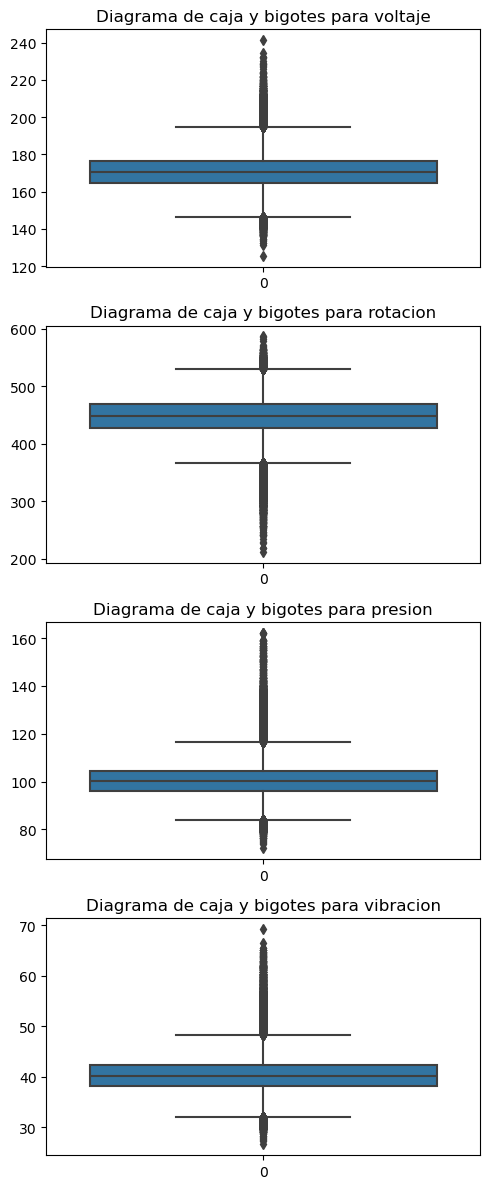

In [115]:
# Seleccionar las columnas de interés
columnas = ['voltaje','rotacion','presion', 'vibracion']

# Crear una figura con subplots para cada columna
fig, axs = plt.subplots(nrows=len(columnas), ncols=1, figsize=(5, 3*len(columnas)))

# Iterar sobre las columnas y crear un diagrama de caja y bigotes para cada una
for i, columna in enumerate(columnas):
    sns.boxplot(data=df_union_resampled[columna], ax=axs[i])
    axs[i].set_title(f'Diagrama de caja y bigotes para {columna}')

# Mostrar la figura
plt.tight_layout()
plt.show()

In [117]:
# Calcular los cuartiles
Q1 = df_union_resampled['rotacion'].quantile(0.25)
Q3 = df_union_resampled['rotacion'].quantile(0.75)

# Calcular el rango intercuartil (IQR)
IQR = Q3 - Q1

# Definir el límite superior
limite_superior = Q3 + 1.5 * IQR

# Ajustar los valores que están por encima del límite superior
df_union_resampled.loc[df_union_resampled['rotacion'] > limite_superior, 'rotacion'] = limite_superior

In [119]:
# Calcular los cuartiles
Q1 = df_union_resampled['presion'].quantile(0.25)
Q3 = df_union_resampled['presion'].quantile(0.75)

# Calcular el rango intercuartil (IQR)
IQR = Q3 - Q1

# Definir el límite inferior
limite_inferior = Q1 - 1.5 * IQR

# Ajustar los valores que están por debajo del límite inferior
df_union_resampled.loc[df_union_resampled['presion'] < limite_inferior, 'presion'] = limite_inferior

In [121]:
# Calcular los cuartiles
Q1 = df_union_resampled['vibracion'].quantile(0.25)
Q3 = df_union_resampled['vibracion'].quantile(0.75)

# Calcular el rango intercuartil (IQR)
IQR = Q3 - Q1

# Definir los límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Ajustar los valores que están fuera del rango
df_union_resampled.loc[df_union_resampled['vibracion'] < limite_inferior, 'vibracion'] = limite_inferior

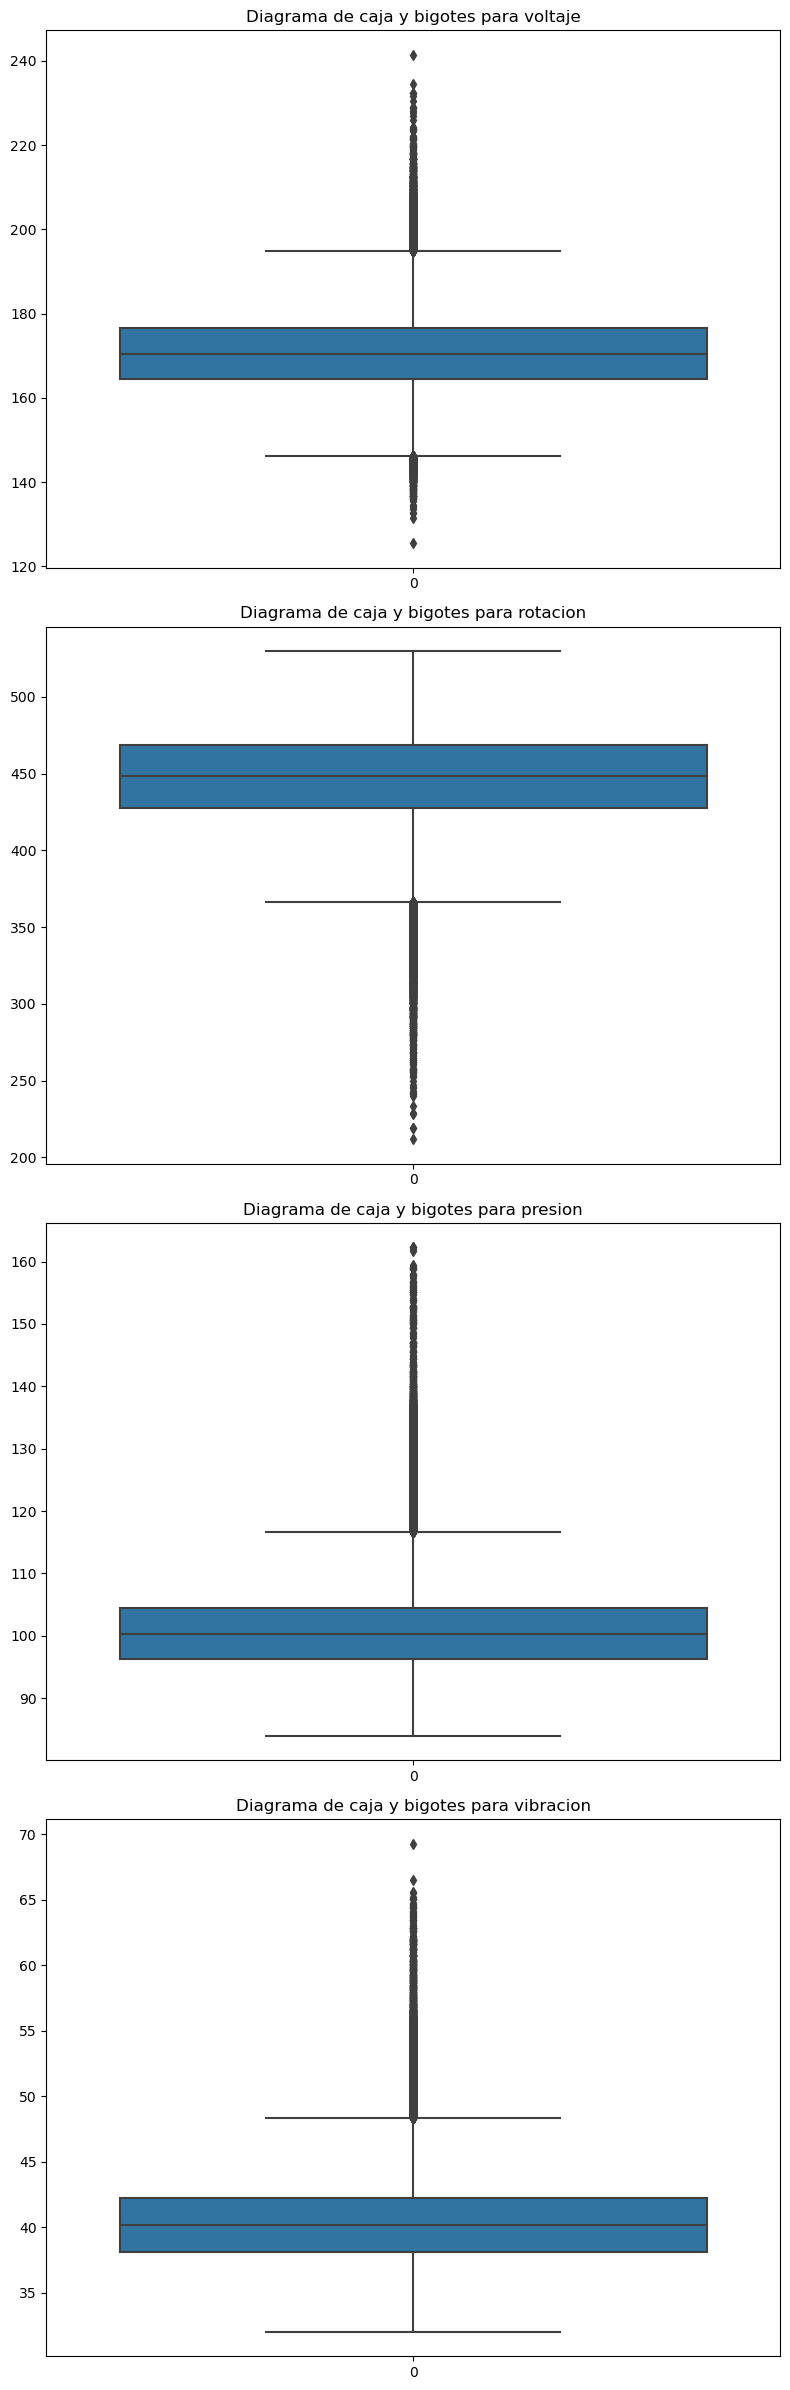

In [123]:
# ahora volvemos a graficar
columnas = ['voltaje','rotacion','presion', 'vibracion']

# Crear una figura con subplots para cada columna
fig, axs = plt.subplots(nrows=len(columnas), ncols=1, figsize=(8, 6*len(columnas)))

# Iterar sobre las columnas y crear un diagrama de caja y bigotes para cada una
for i, columna in enumerate(columnas):
    sns.boxplot(data=df_union_resampled[columna], ax=axs[i])
    axs[i].set_title(f'Diagrama de caja y bigotes para {columna}')

# Mostrar la figura
plt.tight_layout()
plt.show()

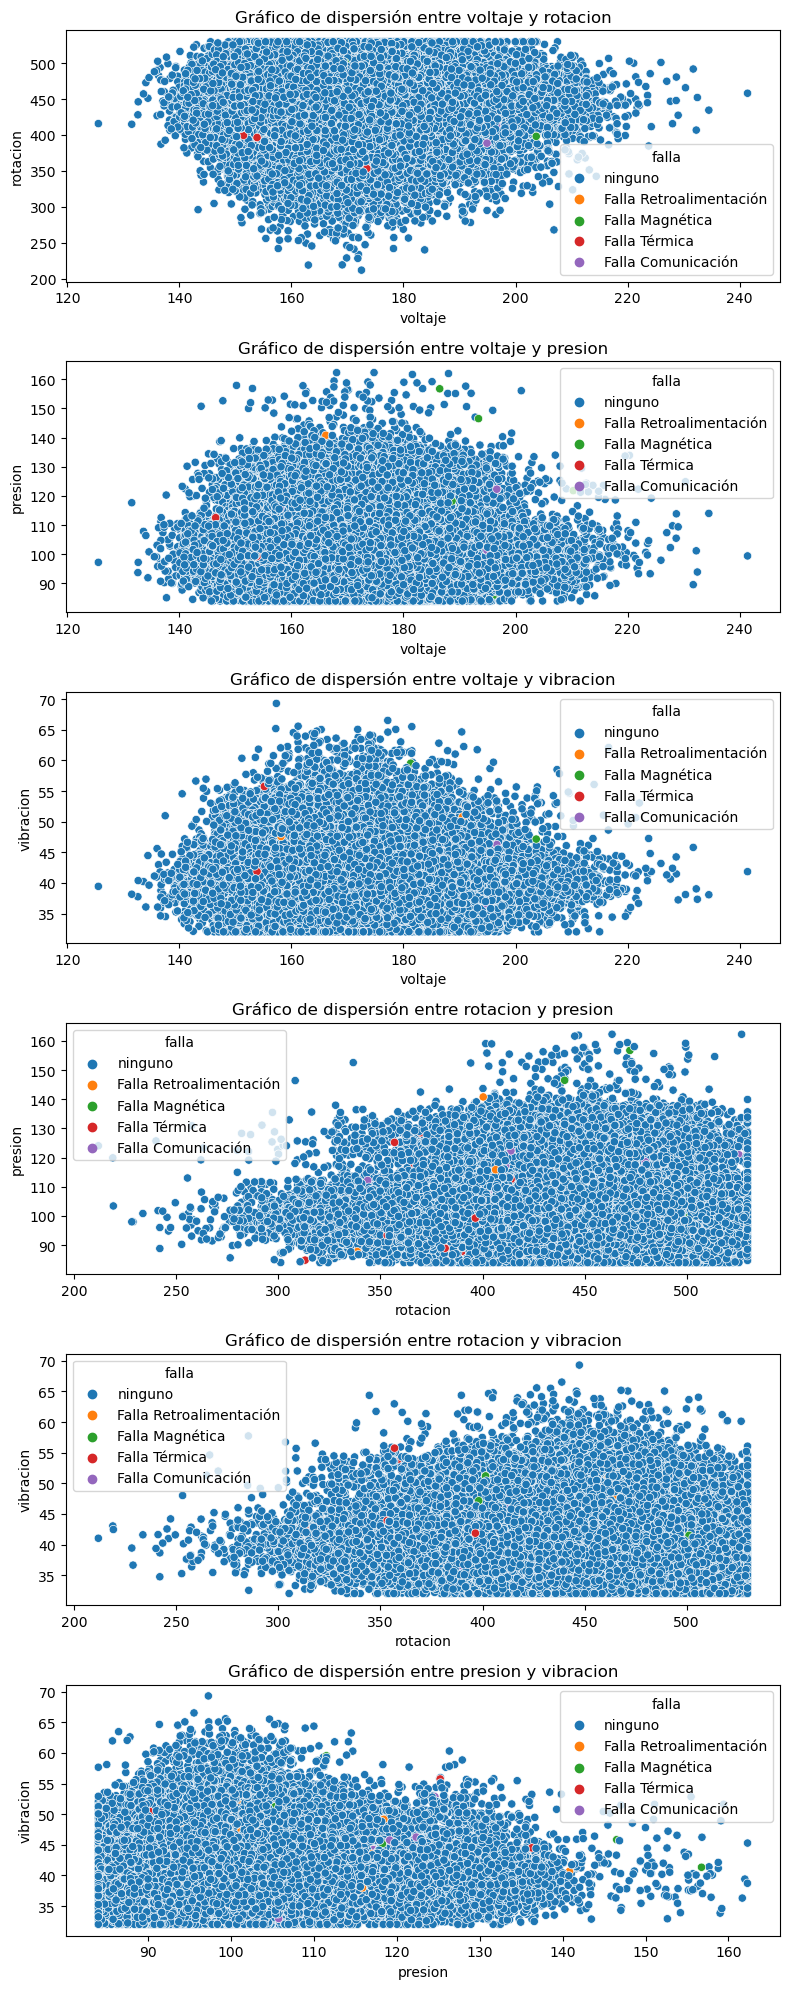

In [125]:
# Crear una figura con subplots para cada par de columnas
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(8, 20))
# Definir las columnas numéricas
columnas_numericas = ['voltaje', 'rotacion', 'presion', 'vibracion']

# Definir los pares de columnas
pares_columnas = [('voltaje', 'rotacion'), ('voltaje', 'presion'), ('voltaje', 'vibracion'),
                   ('rotacion', 'presion'), ('rotacion', 'vibracion'), ('presion', 'vibracion')]
# Iterar sobre los pares de columnas y crear un gráfico de dispersión para cada par
for i, par in enumerate(pares_columnas):
    sns.scatterplot(data=df_union_resampled, x=par[0], y=par[1], hue='falla', ax=axs[i])
    axs[i].set_title(f'Gráfico de dispersión entre {par[0]} y {par[1]}')
# Mostrar la figura
plt.tight_layout()
plt.show()

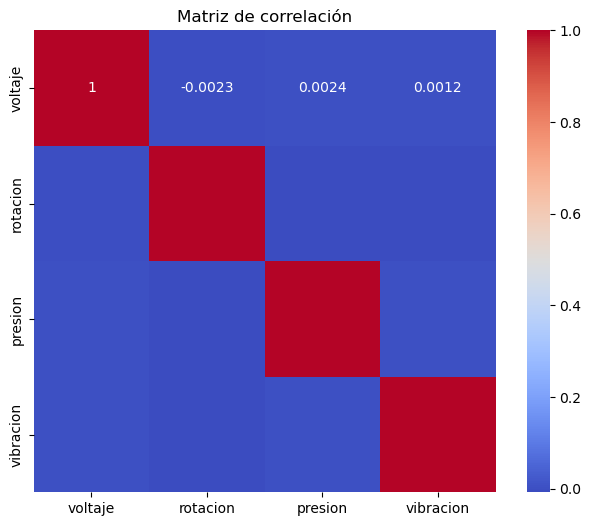

In [127]:
# Calcular la matriz de correlación
corr_matrix = df_union_resampled[['voltaje', 'rotacion', 'presion', 'vibracion']].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Matriz de correlación')
plt.show()

In [129]:
from scipy.stats import f_oneway

# Definir las variables independientes y la variable dependiente
falla_ninguno = df_union_resampled[df_union_resampled['falla'] == 'ninguno']
falla_otro = df_union_resampled[df_union_resampled['falla'] != 'ninguno']

# Realizar el análisis de varianza para cada variable independiente
for columna in ['voltaje', 'rotacion', 'presion', 'vibracion']:
    f_stat, p_val = f_oneway(falla_ninguno[columna], falla_otro[columna])
    print(f'Variable: {columna}')
    print(f'F-statistic: {f_stat}')
    print(f'p-value: {p_val}')
    if p_val < 0.05:
        print('Hay una diferencia significativa entre las medias de los grupos')
    else:
        print('No hay una diferencia significativa entre las medias de los grupos')
    print('---')

Variable: voltaje
F-statistic: 19.878689785771982
p-value: 8.254568379384884e-06
Hay una diferencia significativa entre las medias de los grupos
---
Variable: rotacion
F-statistic: 49.83514772573807
p-value: 1.6759137165676322e-12
Hay una diferencia significativa entre las medias de los grupos
---
Variable: presion
F-statistic: 47.79457765162151
p-value: 4.742638482505628e-12
Hay una diferencia significativa entre las medias de los grupos
---
Variable: vibracion
F-statistic: 76.36700347792276
p-value: 2.367636819952446e-18
Hay una diferencia significativa entre las medias de los grupos
---


In [131]:
itables.show(df_union_resampled)

In [133]:
import pandas as pd

#CONVERSION DE FECHA_TRUNCADA A NUMERO

# Asegúrate de que 'fecha_truncada' esté en formato de fecha
df_union_resampled_copy = df_union_resampled.copy()

# Convertir la columna 'fecha_truncada' en valores enteros (días desde la fecha mínima)
df_union_resampled_copy['fecha_truncada'] = pd.to_datetime(df_union_resampled_copy['fecha_truncada'])
df_union_resampled_copy['fecha_truncada'] = df_union_resampled_copy['fecha_truncada'].astype('int64')

# Mostrar las primeras filas del nuevo DataFrame para verificar
print(df_union_resampled_copy.head())



   maquina_ID       fecha_truncada     voltaje    rotacion     presion  \
0           1  1420092000000000000  170.028993  449.533798   94.592122   
1           1  1420102800000000000  164.192565  403.949857  105.687417   
2           1  1420113600000000000  168.134445  435.781707  107.793709   
3           1  1420124400000000000  165.514453  430.472823  101.703289   
4           1  1420135200000000000  168.809347  437.111120   90.911060   

   vibracion    falla T_Mantenimiento  falla_ocurrida             TMEF  \
0  40.893502  ninguno        SinTarea               0  9 days 13:30:00   
1  34.255891  ninguno        SinTarea               0  9 days 13:30:00   
2  41.239405  ninguno        SinTarea               0  9 days 13:30:00   
3  40.373739  ninguno        SinTarea               0  9 days 13:30:00   
4  41.738542  ninguno        SinTarea               0  9 days 13:30:00   

   mantenimiento_realizado                      TMEB  
0                        0 2 days 14:28:41.739130434  


In [135]:
#CODIGO PARA VOLVER A COVERTIR A FECHA

#df_union_resampled_copy['fecha_truncada'] = pd.to_datetime(df_union_resampled_copy['fecha_truncada'])

In [137]:
df_union_resampled_copy.head()

maquina_ID       fecha_truncada     voltaje    rotacion     presion  \
0           1  1420092000000000000  170.028993  449.533798   94.592122   
1           1  1420102800000000000  164.192565  403.949857  105.687417   
2           1  1420113600000000000  168.134445  435.781707  107.793709   
3           1  1420124400000000000  165.514453  430.472823  101.703289   
4           1  1420135200000000000  168.809347  437.111120   90.911060   

   vibracion    falla T_Mantenimiento  falla_ocurrida             TMEF  \
0  40.893502  ninguno        SinTarea               0  9 days 13:30:00   
1  34.255891  ninguno        SinTarea               0  9 days 13:30:00   
2  41.239405  ninguno        SinTarea               0  9 days 13:30:00   
3  40.373739  ninguno        SinTarea               0  9 days 13:30:00   
4  41.738542  ninguno        SinTarea               0  9 days 13:30:00   

   mantenimiento_realizado                      TMEB  
0                        0 2 days 14:28:41.739130434  
1                        0 2 days 14:28:41.739130434  
2                        0 2 days 14:28:41.739130434  
3                        0 2 days 14:28:41.739130434  
4                        0 2 days 14:28:41.739130434

## ALGORITMO RANDOM FOREST ##

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Preparar los datos
X = df_union_resampled_copy[['maquina_ID','fecha_truncada','voltaje', 'rotacion', 'presion', 'vibracion']]
y = df_union_resampled_copy['falla']

# Convertir la columna `falla` a una variable numérica
le = LabelEncoder()
y = le.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo
model = RandomForestClassifier(n_estimators=1000, random_state=128)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir los valores de la variable dependiente
y_pred = model.predict(X_test)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9973981513180418
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        44
           4       1.00      1.00      1.00     58268

    accuracy                           1.00     58420
   macro avg       0.20      0.20      0.20     58420
weighted avg       0.99      1.00      1.00     58420

Confusion Matrix:
[[    0     0     0     0    20]
 [    0     0     0     0    48]
 [    0     0     0     0    40]
 [    0     0     0     0    44]
 [    0     0     0     0 58268]]


C:\Users\raulc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\raulc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\raulc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [142]:
from imblearn.over_sampling import RandomOverSampler

# Definir el conjunto de datos
X = df_union_resampled_copy[['maquina_ID','fecha_truncada','voltaje', 'rotacion', 'presion', 'vibracion']]
y = df_union_resampled_copy['falla']

# Crear un objeto de oversampling
ros = RandomOverSampler(random_state=20)

# Realizar el oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

In [144]:
itables.show(df_union_resampled_copy)

In [146]:
#CODIGO PARA VOLVER A CONVERTIR A FALLAS EN VARIABLE CATEGORICA

#df_union_resampled_copy['falla'] = le.inverse_transform(df_union_resampled_copy['falla'])

C:\Users\raulc\AppData\Local\Temp\ipykernel_5832\2391650130.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


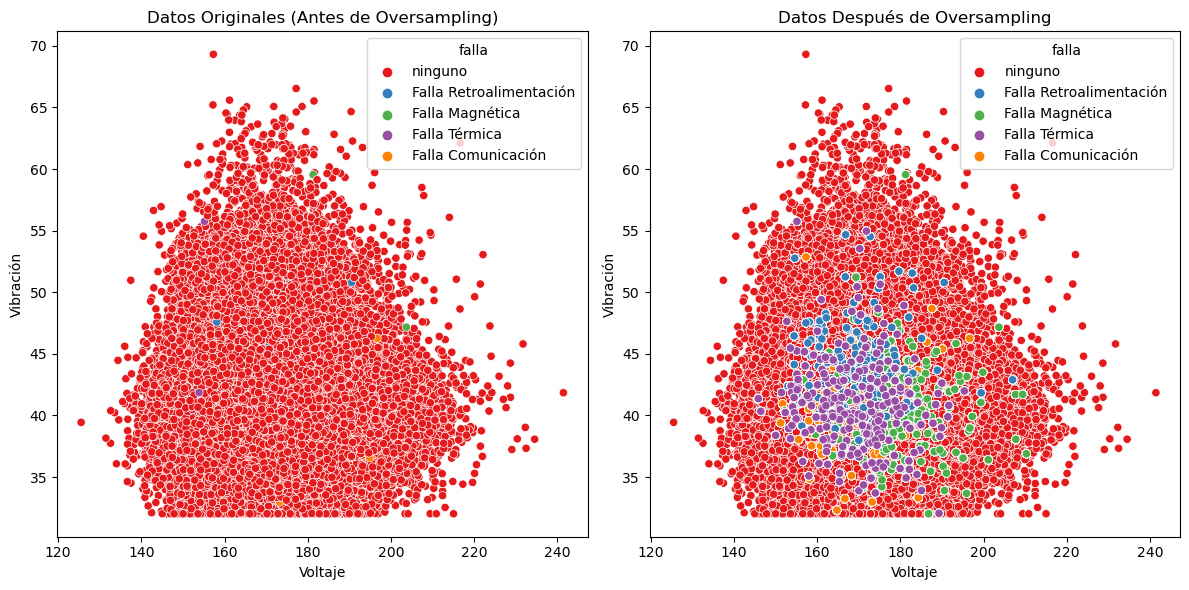

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar los datos originales
plt.figure(figsize=(12, 6))

# Graficar el conjunto original
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_union_resampled_copy['voltaje'], y=df_union_resampled_copy['vibracion'], hue=df_union_resampled['falla'], palette='Set1')
plt.title('Datos Originales (Antes de Oversampling)')
plt.xlabel('Voltaje')
plt.ylabel('Vibración')

# Graficar los datos después de hacer oversampling
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_resampled['voltaje'], y=X_resampled['vibracion'], hue=y_resampled, palette='Set1')
plt.title('Datos Después de Oversampling')
plt.xlabel('Voltaje')
plt.ylabel('Vibración')

plt.tight_layout()
plt.show()


In [150]:
# Crear un objeto de LabelEncoder PARA LAS FALLAS CODIGO DEL 0 AL 4

le = LabelEncoder()
df_union_resampled_copy['falla'] = le.fit_transform(df_union_resampled_copy['falla'])

In [152]:
from imblearn.over_sampling import RandomOverSampler

# Definir el conjunto de datos
X = df_union_resampled_copy[['maquina_ID','fecha_truncada','voltaje', 'rotacion', 'presion', 'vibracion']]
y = df_union_resampled_copy['falla']

# Crear un objeto de oversampling
ros = RandomOverSampler(random_state=20)

# Realizar el oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

In [154]:
#PARA INVERTIR LA TRANSFORMACION MULTICLASE
#Mapeo valores numéricos a etiquetas originales:

#----IMPORTANTE-----

#--------------0 -> Falla Comunicación
#--------------1 -> Falla Magnética
#--------------2 -> Falla Retroalimentación
#--------------3 -> Falla Térmica
#--------------4 -> ninguno

# Para revertir la transformación y obtener los valores originales:
#df_union_resampled_copy['falla'] = le.inverse_transform(df_union_resampled_copy['falla'])
# Para imprimir cada valor numérico junto con su etiqueta original:
#mapping = dict(zip(range(len(le.classes_)), le.classes_))
#print("Mapeo valores numéricos a etiquetas originales:")
#for num, label in mapping.items():
    #print(f"{num} -> {label}")

In [156]:
itables.show(y_resampled)

In [158]:
#MODELO ALGORITMO RANDOM FOREST CON EL AJUSTE DE LA DATA 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definir el conjunto de datos reequilibrado
X_resampled, y_resampled = X_resampled, y_resampled

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear un modelo de Random Forest con pesos de clase
model_rf = RandomForestClassifier(
    n_estimators=30,  # Reducir el número de estimadores
    max_depth=10,  # Limitar la profundidad máxima
    min_samples_leaf=5,  # Aumentar el número mínimo de muestras por hoja
    random_state=20,
    class_weight='balanced'
)

# Entrenar el modelo
model_rf.fit(X_train, y_train)

# Predecir los valores de la variable dependiente
y_pred_rf = model_rf.predict(X_test)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rf))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.9151420305373377
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     58230
           1       0.93      0.95      0.94     58522
           2       0.91      0.97      0.94     58024
           3       0.93      0.92      0.93     58690
           4       0.91      0.73      0.81     57915

    accuracy                           0.92    291381
   macro avg       0.92      0.91      0.91    291381
weighted avg       0.92      0.92      0.91    291381

Confusion Matrix:
[[58230     0     0     0     0]
 [  926 55440   596     0  1560]
 [  756     0 56489     0   779]
 [ 1588   503   668 54280  1651]
 [ 4067  3526  4072  4034 42216]]


In [160]:
itables.show(y_resampled)

In [166]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Definir el número de folds
k = 5

# Crear un objeto de validación cruzada
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Listas para almacenar los resultados
accuracies = []

# Realizar la validación cruzada
for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Entrenar el modelo
    model_rff = RandomForestClassifier(n_estimators=30, random_state=20, class_weight='balanced')
    model_rff.fit(X_train, y_train)

    # Predecir los valores de la variable dependiente
    y_pred_rff = model_rff.predict(X_test)

    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred_rff)
    accuracies.append(accuracy)

# Calcular la precisión promedio
accuracy_promedio = sum(accuracies) / k
print('Precisión promedio:', accuracy_promedio)

Precisión promedio: 0.9999993136134477


In [168]:
#df_union_resampled_copy['fecha_truncada'] = pd.to_datetime(df_union_resampled_copy['fecha_truncada'])

In [170]:
itables.show(X_test)

In [386]:
#CONVERTIR A DF X_TEST Y LUEGO CONVERTIR LA FECHA A DATATIME

X_test=pd.DataFrame(X_test)
X_test['fecha_truncada'] = pd.to_datetime(X_test['fecha_truncada'])

In [388]:
X_test.dtypes

maquina_ID                 int32
fecha_truncada    datetime64[ns]
voltaje                  float64
rotacion                 float64
presion                  float64
vibracion                float64
dtype: object

In [501]:
itables.show(X_resampled)

## ALGORITMO REDES NEURONALES ARTIFICIALES ##

In [172]:
#PRUEBA PARA ALGORITMO REDES NEURONALES
from imblearn.over_sampling import RandomOverSampler

# Definir el conjunto de datos
X1 = df_union_resampled_copy[['voltaje', 'rotacion', 'presion', 'vibracion']]
y1 = df_union_resampled_copy['falla']

# Crear un objeto de oversampling
ros = RandomOverSampler(random_state=20)

# Realizar el oversampling
X_resampled1, y_resampled1 = ros.fit_resample(X1, y1)

In [176]:
# Importar las bibliotecas necesarias
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Definir el conjunto de datos reequilibrado
X_resampled1, y_resampled1 = X_resampled1, y_resampled1

# Convertir las etiquetas a categóricas si es necesario
# Esto depende del número de clases y la función de activación utilizada en la capa de salida
y_resampled_N = to_categorical(y_resampled1)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resampled1, y_resampled_N, test_size=0.2, random_state=42)

# Crear el modelo de red neuronal
model_rn = Sequential()
model_rn.add(Dense(350, activation='relu', input_shape=(X_train1.shape[1],)))
model_rn.add(Dense(128, activation='relu'))
model_rn.add(Dense(y_train1.shape[1], activation='softmax'))

# Compilar el modelo
model_rn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir el callback para early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

# Entrenar el modelo
history = model_rn.fit(
    X_train1, y_train1,
    epochs=50,
    batch_size=256,
    validation_data=(X_test1, y_test1),
    callbacks=[early_stopping])

# Predecir los valores de la variable dependiente
y_pred_rn = model_rn.predict(X_test1)
y_pred_class = y_pred_rn.argmax(axis=1)
y_test_class = y_test1.argmax(axis=1)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test_class, y_pred_class))
print('Classification Report:')
print(classification_report(y_test_class, y_pred_class))
print('Confusion Matrix:')
print(confusion_matrix(y_test_class, y_pred_class))

Epoch 1/50


C:\Users\raulc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4553/4553 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.3602 - loss: 1.9758 - val_accuracy: 0.4286 - val_loss: 1.3437
Epoch 2/50
4553/4553 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4293 - loss: 1.3464 - val_accuracy: 0.4598 - val_loss: 1.2892
Epoch 3/50
4553/4553 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4611 - loss: 1.2798 - val_accuracy: 0.4937 - val_loss: 1.2159
Epoch 4/50
4553/4553 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.4995 - loss: 1.1943 - val_accuracy: 0.5214 - val_loss: 1.1389
Epoch 5/50
4553/4553 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5369 - loss: 1.1176 - val_accuracy: 0.5655 - val_loss: 1.0676
Epoch 6/50
4553/4553 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5676 - loss: 1.0502 - val_accuracy: 0.5867 - val_loss: 1.0135
Epoch 7/50
4553/4553 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5885 - loss: 1.0009 - val_accuracy: 0.5996 - val_loss: 0.9629
Epoch 8/50
4553/4553 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6069 - loss: 0.9617 - val_ac

## ALGORITMO XGBOOST ##

In [178]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder



# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear un modelo de XGBoost
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',  # Función de pérdida para clasificación multiclase
    num_class=len(le.classes_),  # Número de clases
    max_depth=6,  # Profundidad máxima del árbol
    learning_rate=0.1,  # Tasa de aprendizaje
    n_estimators=60,  # Número de árboles
    n_jobs=-1  # Número de hilos
)

# Entrenar el modelo
model_xgb.fit(X_train, y_train)

# Predecir los valores de la variable dependiente
y_pred_xg = model_xgb.predict(X_test)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test, y_pred_xg))
print('Classification Report:')
print(classification_report(y_test, y_pred_xg))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_xg))

Accuracy: 0.9016236473895003
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     58230
           1       0.88      0.99      0.93     58522
           2       0.91      0.98      0.94     58024
           3       0.88      0.94      0.91     58690
           4       0.93      0.59      0.73     57915

    accuracy                           0.90    291381
   macro avg       0.90      0.90      0.89    291381
weighted avg       0.90      0.90      0.89    291381

Confusion Matrix:
[[58230     0     0     0     0]
 [    0 57886   326     0   310]
 [    0     0 56963   369   692]
 [  934   464   657 55224  1411]
 [ 4591  7270  4595  7046 34413]]


In [559]:
itables.show(X_resampled)

## ALGORITMO ARBOLES DE DECISION ##

In [180]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, 
                                                    random_state=42)
# Crear un árbol de decisión

clf = DecisionTreeClassifier(
    criterion='gini',            # 'gini' o 'entropy' para la función de impureza (default 'gini')
    splitter='best',             # 'best' o 'random' para elegir el punto de división (default 'best')
    max_depth=380,              # Profundidad máxima del árbol (None = sin límite)
    max_features=40,           # Número de características a considerar para el mejor split (None = todas)
    max_leaf_nodes=320,         # Número máximo de hojas (None = sin límite)
    class_weight='balanced',           # None o 'balanced' para ajustar pesos según clases desbalanceadas
    random_state=128             # Semilla para reproducibilidad
   
)
# Entrenar el modelo
clf.fit(X_train, y_train)

# Predecir los valores
y_pred_ad = clf.predict(X_test)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test, y_pred_ad))
print('Classification Report:')
print(classification_report(y_test, y_pred_ad))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_ad))

Accuracy: 0.8860769919795731
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     58230
           1       0.87      1.00      0.93     58522
           2       0.89      0.99      0.94     58024
           3       0.83      0.95      0.89     58690
           4       0.98      0.48      0.65     57915

    accuracy                           0.89    291381
   macro avg       0.90      0.89      0.87    291381
weighted avg       0.90      0.89      0.87    291381

Confusion Matrix:
[[58230     0     0     0     0]
 [    0 58522     0     0     0]
 [  372     0 57652     0     0]
 [  693   900   912 55710   475]
 [ 4071  7919  6499 11354 28072]]


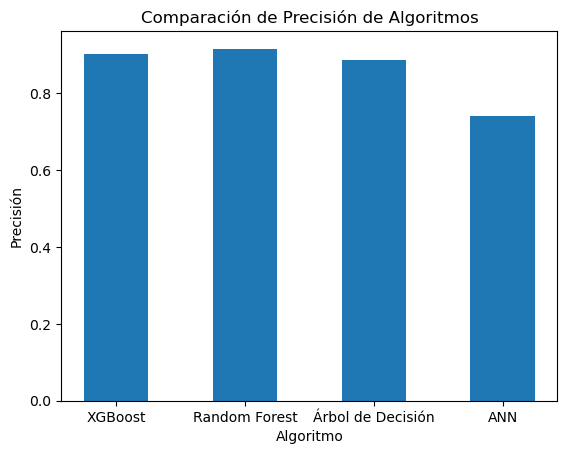

In [184]:
import matplotlib.pyplot as plt

# Precisión de los algoritmos
xgb_precision = 0.9016236473895003
rf_precision = 0.9151420305373377
ad_precision = 0.8860769919795731
rn_precision = 0.7405321554940095

# Crear una gráfica de barras
plt.bar(['XGBoost', 'Random Forest', 'Árbol de Decisión', 'ANN'],
        [xgb_precision, rf_precision, ad_precision, rn_precision], width=0.5)  

plt.xlabel('Algoritmo')
plt.ylabel('Precisión')
plt.title('Comparación de Precisión de Algoritmos')
plt.show()

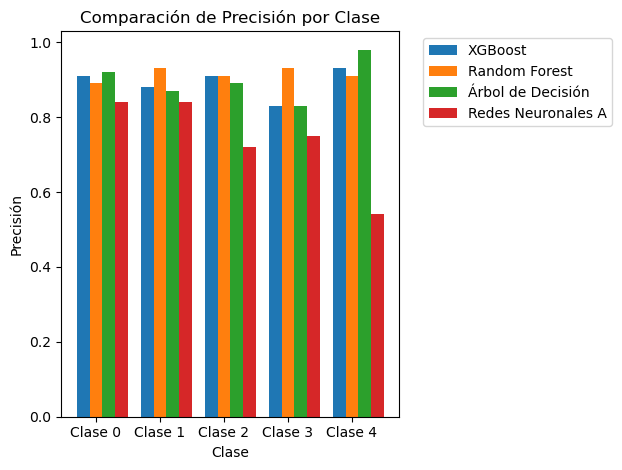

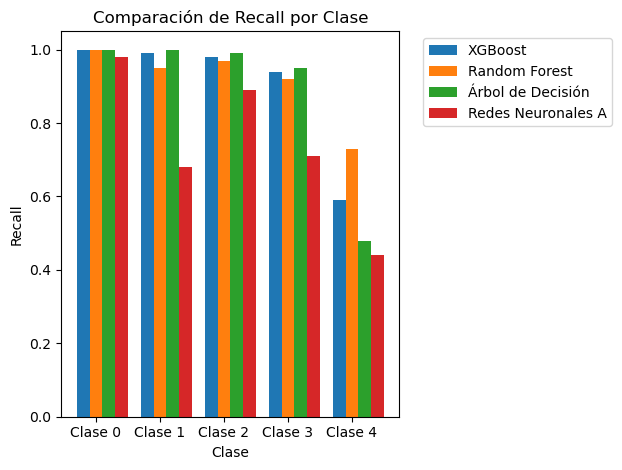

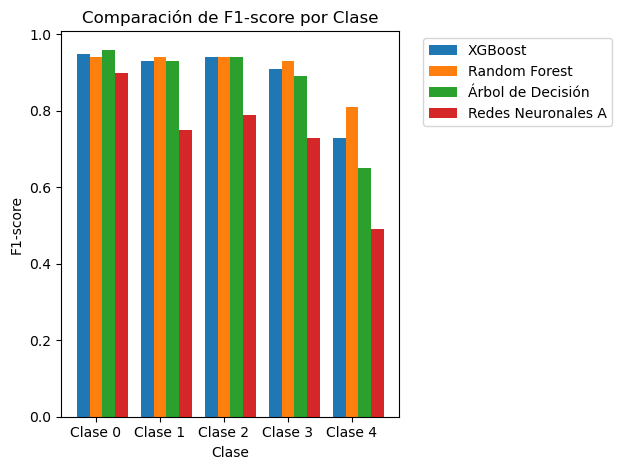

In [201]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas de XGBoost
xgb_precision = [0.91, 0.88, 0.91, 0.83, 0.93]
xgb_recall = [1.00, 0.99, 0.98, 0.94, 0.59]
xgb_f1 = [0.95, 0.93, 0.94, 0.91, 0.73]

# Métricas de Random Forest
rf_precision = [0.89, 0.93, 0.91, 0.93, 0.91]
rf_recall = [1.00, 0.95, 0.97, 0.92, 0.73]
rf_f1 = [0.94, 0.94, 0.94, 0.93, 0.81]

# Métricas de Árbol de Decisión
ad_precision = [0.92, 0.87, 0.89, 0.83, 0.98]
ad_recall = [1.00, 1.00, 0.99, 0.95, 0.48]
ad_f1 = [0.96, 0.93, 0.94, 0.89, 0.65]

# Métricas de redes neuronales artificiales
rn_precision = [0.84, 0.84, 0.72, 0.75, 0.54]
rn_recall = [0.98, 0.68, 0.89, 0.71, 0.44]
rn_f1 = [0.90, 0.75, 0.79, 0.73, 0.49]

# Crear una gráfica de barras
x = np.arange(5)
width = 0.2

plt.figure()
plt.bar(x - width, xgb_precision, width, label='XGBoost')
plt.bar(x, rf_precision, width, label='Random Forest')
plt.bar(x + width, ad_precision, width, label='Árbol de Decisión')
plt.bar(x + 2*width, rn_precision, width, label='Redes Neuronales A')  
plt.xticks(x, ['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3', 'Clase 4'])
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Comparación de Precisión por Clase')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico de Recall
plt.figure()
plt.bar(x - width, xgb_recall, width, label='XGBoost')
plt.bar(x, rf_recall, width, label='Random Forest')
plt.bar(x + width, ad_recall, width, label='Árbol de Decisión')
plt.bar(x + 2*width, rn_recall, width, label='Redes Neuronales A')  
plt.xticks(x, ['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3', 'Clase 4'])
plt.xlabel('Clase')
plt.ylabel('Recall')
plt.title('Comparación de Recall por Clase')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico de F1-score
plt.figure()
plt.bar(x - width, xgb_f1, width, label='XGBoost')
plt.bar(x, rf_f1, width, label='Random Forest')
plt.bar(x + width, ad_f1, width, label='Árbol de Decisión')
plt.bar(x + 2*width, rn_f1, width, label='Redes Neuronales A')  
plt.xticks(x, ['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3', 'Clase 4'])
plt.xlabel('Clase')
plt.ylabel('F1-score')
plt.title('Comparación de F1-score por Clase')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Accuracy: 0.9151420305373377
Confusion Matrix:
[[58230     0     0     0     0]
 [  926 55440   596     0  1560]
 [  756     0 56489     0   779]
 [ 1588   503   668 54280  1651]
 [ 4067  3526  4072  4034 42216]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     58230
           1       0.93      0.95      0.94     58522
           2       0.91      0.97      0.94     58024
           3       0.93      0.92      0.93     58690
           4       0.91      0.73      0.81     57915

    accuracy                           0.92    291381
   macro avg       0.92      0.91      0.91    291381
weighted avg       0.92      0.92      0.91    291381



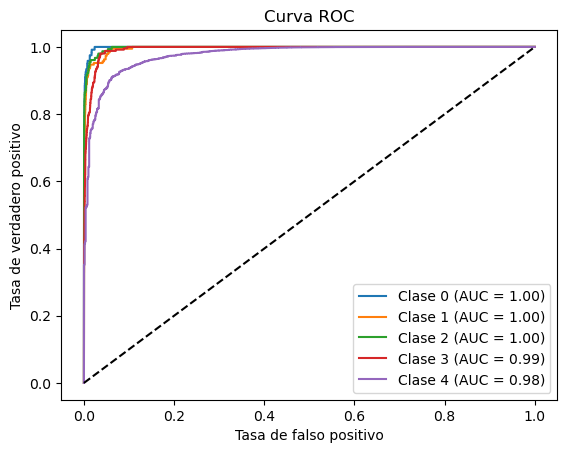

In [162]:
#ANALISIS PARA ALGORITMO RANDOM FOREST

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Precisión
accuracy = accuracy_score(y_test, y_pred_rf)
print('Accuracy:', accuracy)

# Matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix:')
print(conf_mat)

# Informe de clasificación
class_report = classification_report(y_test, y_pred_rf)
print('Classification Report:')
print(class_report)

# Curva ROC y área bajo la curva ROC para clasificación multiclase
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_proba = model_rf.predict_proba(X_test)

for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falso positivo')
plt.ylabel('Tasa de verdadero positivo')
plt.title('Curva ROC')
plt.legend()
plt.show()

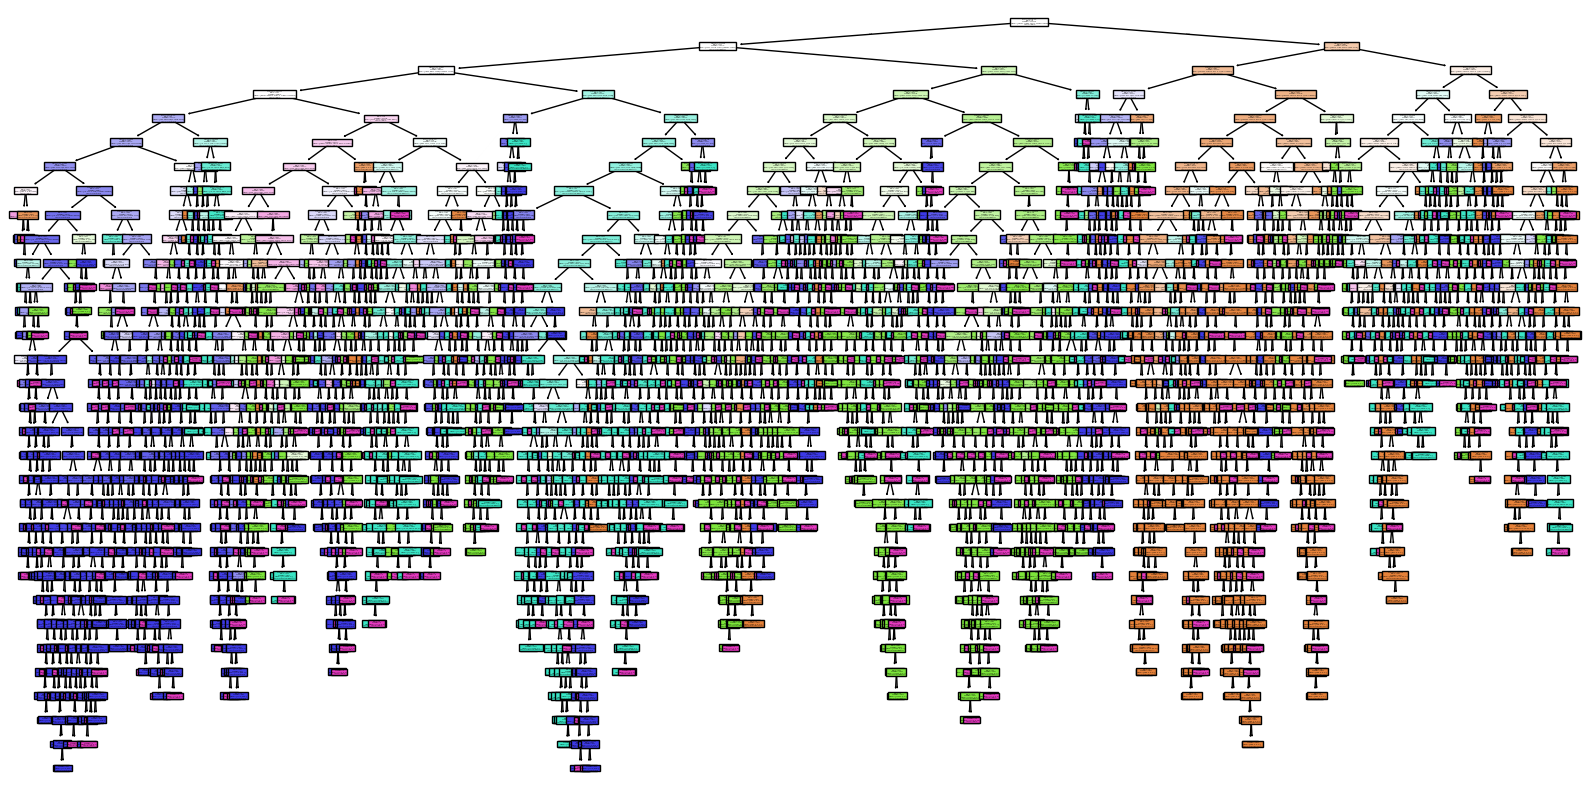

In [155]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Cargar los datos
# Supongamos que tenemos un DataFrame llamado df con las características y la variable objetivo

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear un árbol de decisión
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X_resampled.columns, class_names=[str(c) for c in le.classes_], filled=True)
plt.show()